## Simple Stellar Population (SSP)
Here we will explain the central routine of **Chempy**. The observational counterpart of an SSP is the open cluster. All stars are approximately born at the same time, and from the same ISM abundances. Therefore the SSP is characterized by its total **mass**, its birth **age** and its **initial elemental composition**. When assuming **stellar lifetimes**, an **IMF** and **nucleosynthetic feedback** we can calculate its feedback over time.
You will see how this is realized in Chempy.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../source/

/home/jan/Arbeitsfläche/Chempy_git/source


In [3]:
from parameter import ModelParameters
a = ModelParameters()

First we load the default values of:
- IMF
- SN2, AGB and SNIa feedback

In [4]:
from imf import IMF
basic_imf = IMF(a.mmin,a.mmax,a.mass_steps)
getattr(basic_imf, a.imf_type_name)((a.chabrier_para1,a.chabrier_para2,a.chabrier_para3,a.high_mass_slope))
from yields import SN2_feedback
from yields import AGB_feedback
from yields import SN1a_feedback
basic_sn2 = SN2_feedback()
getattr(basic_sn2, "Nomoto2013")()
basic_1a = SN1a_feedback()
getattr(basic_1a, "Seitenzahl")()
basic_agb = AGB_feedback()
getattr(basic_agb, "Karakas_net_yield")()
elements_to_trace = list(np.unique(basic_agb.elements+basic_sn2.elements+basic_1a.elements))
print elements_to_trace

['Al', 'Ar', 'B', 'Be', 'C', 'Ca', 'Cl', 'Co', 'Cr', 'Cu', 'F', 'Fe', 'Ga', 'Ge', 'H', 'He', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'Ne', 'Ni', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V', 'Zn']


We have to do the following choices when initialising the SSP class (in brackets our choices are given):

- Which metallicity does it have (Solar)
- How long will the SSP live and at which timesteps do we want the feedback to be evaluated (Delta t = 0.025 for 13.5 Gyr)
- What is the lifetime rroutine (Argast+ 2000)
- How should the interpolation in metallicity from the yield tables be (logarithmic)
- Do we want to safe the net yields as well (No)


In [5]:
from solar_abundance import solar_abundances
basic_solar = solar_abundances()
getattr(basic_solar, 'Asplund09')()
time_steps = np.linspace(0.,13.5,541)
from weighted_yield import SSP
basic_ssp = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 


This initialises the SSP class. It calculates the inverse IMF (stars of which minimal mass will be dead until each time-step) and it also initialises the feedback table, which need to be filled by the feedback from each subroutine, representing a specific nucleosynthetic process (CC-SN, AGB star, SN Ia)

0.0 100.0
0.025 10.4384857378
0.05 7.16435126426
0.075 5.87896782591
0.1 5.14928794088


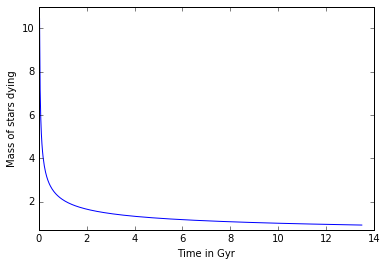

In [6]:
plt.plot(time_steps[1:],basic_ssp.inverse_imf[1:])
plt.ylabel('Mass of stars dying')
plt.xlabel('Time in Gyr')
plt.ylim((0.7,11))
for i in range(5):
    print time_steps[i],basic_ssp.inverse_imf[i]

In order to calculate the feedback for the CC-SN and AGB star we will need to provide the elemental abundances at birth, for which we will use solar abundances for now

In [7]:
solar_fractions = []
elements = np.hstack(basic_solar.all_elements)
for item in elements_to_trace:
    solar_fractions.append(float(basic_solar.fractions[np.where(elements==item)]))

[5.563317545510848e-05, 7.34111756843463e-05, 4.876778217546731e-09, 1.3155188996600041e-10, 0.002365023484418829, 6.41465316072021e-05, 4.404738484543124e-06, 4.213345998653204e-06, 1.6604962857880255e-05, 7.200378999789835e-07, 3.6560070484966384e-07, 0.0012919670374607077, 5.592979191864829e-08, 2.3737937043174234e-07, 0.7373977678803461, 0.24923529618045798, 3.0649614239221718e-06, 9.240366194131658e-09, 0.0007078850877053318, 1.0817834648526598e-05, 0.0006927921611701996, 2.9228178501160395e-05, 0.0012565559869137095, 7.126173736917507e-05, 0.0057328533776146535, 5.82453279790028e-06, 0.00030924193524042935, 4.645729836094753e-08, 0.0006648892298164044, 3.121068839125633e-06, 3.172041547067832e-07, 1.7366490153100512e-06]


In [8]:
basic_ssp.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
basic_ssp.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
basic_ssp.sn1a_feedback(list(basic_1a.elements), list(basic_1a.metallicities), dict(basic_1a.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), a.stochastic_IMF)

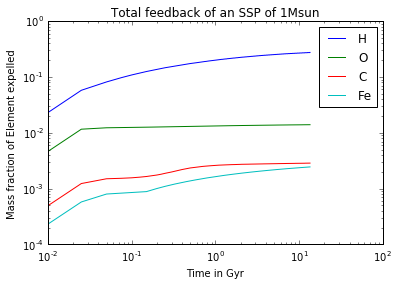

In [9]:
plt.plot(time_steps,np.cumsum(basic_ssp.table['H']), label = 'H')
plt.plot(time_steps,np.cumsum(basic_ssp.table['O']), label = 'O')
plt.plot(time_steps,np.cumsum(basic_ssp.table['C']), label = 'C')
plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = 'Fe')
#plt.plot(time_steps,basic_ssp.sn2_table['O'], label = 'O net yield')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction of Element expelled')
plt.title('Total feedback of an SSP of 1Msun')
plt.xlabel('Time in Gyr')
plt.legend()

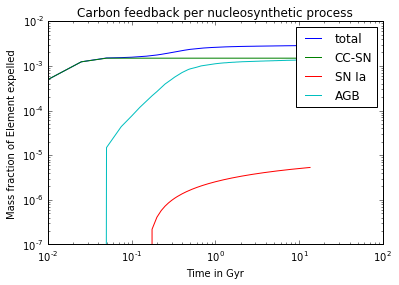

In [10]:
plt.plot(time_steps,np.cumsum(basic_ssp.table['C']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp.sn2_table['C']), label = 'CC-SN')
plt.plot(time_steps,np.cumsum(basic_ssp.sn1a_table['C']), label = 'SN Ia')
plt.plot(time_steps,np.cumsum(basic_ssp.agb_table['C']), label = 'AGB')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Mass fraction of Element expelled')
plt.xlabel('Time in Gyr')
plt.title('Carbon feedback per nucleosynthetic process')
plt.legend()

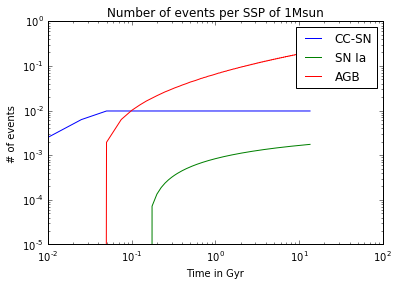

In [11]:
plt.plot(time_steps,np.cumsum(basic_ssp.table['sn2']), label = 'CC-SN')
plt.plot(time_steps,np.cumsum(basic_ssp.table['sn1a']), label = 'SN Ia')
plt.plot(time_steps,np.cumsum(basic_ssp.table['pn']), label = 'AGB')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('# of events')
plt.xlabel('Time in Gyr')
plt.title('Number of events per SSP of 1Msun')
plt.legend()

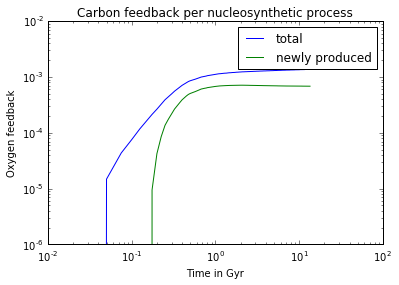

In [12]:
basic_ssp_net = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', True) 
basic_ssp_net.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
plt.plot(time_steps,np.cumsum(basic_ssp.agb_table['C']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp_net.agb_table['C']), label = 'newly produced')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Oxygen feedback')
plt.xlabel('Time in Gyr')
plt.title('Carbon feedback per nucleosynthetic process')
plt.legend()

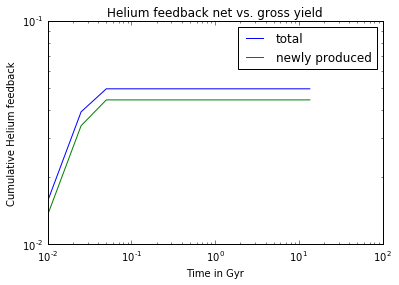

In [19]:
basic_ssp_net = SSP(False, basic_solar.z, basic_imf.x, basic_imf.dm, basic_imf.dn, time_steps, elements_to_trace, 'Argast_2000', 'logarithmic', True)
basic_ssp_net.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
plt.plot(time_steps,np.cumsum(basic_ssp.sn2_table['He']), label = 'total')
plt.plot(time_steps,np.cumsum(basic_ssp_net.sn2_table['He']), label = 'newly produced')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Cumulative Helium feedback')
plt.xlabel('Time in Gyr')
plt.title('Helium feedback net vs. gross yield')
plt.legend()

In the sn2_table the net_yields are stored (only material that was newly produced). We see that for solar elemental abundances the expelled material has a large contribution from the initial stellar abundance.



In [16]:
print basic_ssp.sn2_table['O'][:3],basic_ssp_net.sn2_table['O'][:3]

[ 0.          0.01163893  0.00065099] [ 0.          0.0115185   0.00064764]


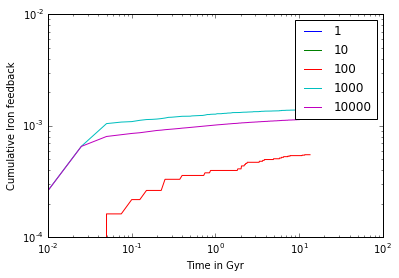

In [35]:
for mass in [1,1e1,1e2,1e3,1e4]:
    basic_imf = IMF(a.mmin,a.mmax,a.mass_steps)
    getattr(basic_imf, a.imf_type_name)((a.chabrier_para1,a.chabrier_para2,a.chabrier_para3,a.high_mass_slope))
    basic_imf.stochastic_sampling(mass)
    basic_ssp = SSP(False, np.copy(basic_solar.z), np.copy(basic_imf.x), np.copy(basic_imf.dm), np.copy(basic_imf.dn), np.copy(time_steps), list(elements_to_trace), 'Argast_2000', 'logarithmic', False) 
    basic_ssp.sn2_feedback(list(basic_sn2.elements), dict(basic_sn2.table), np.copy(basic_sn2.metallicities), float(a.sn2mmin), float(a.sn2mmax),list(solar_fractions))
    basic_ssp.agb_feedback(list(basic_agb.elements), dict(basic_agb.table), list(basic_agb.metallicities), float(a.agbmmin), float(a.agbmmax),list(solar_fractions))
    basic_ssp.sn1a_feedback(list(basic_1a.elements), list(basic_1a.metallicities), dict(basic_1a.table), str(a.time_delay_functional_form), float(a.sn1ammin), float(a.sn1ammax), [a.N_0,a.sn1a_time_delay,a.sn1a_exponent,a.dummy],float(a.total_mass), True)
    plt.plot(time_steps,np.cumsum(basic_ssp.table['Fe']), label = '%d' %(mass))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Cumulative Iron feedback')
plt.xlabel('Time in Gyr')
plt.legend()